In [16]:
%matplotlib inline

In [17]:
import pandas as pd
import numpy as np
import glob
import json, re
import time
from dateutil.parser import parse
import requests, zipfile, StringIO 

### Read json into Pandas DataFrame

In [18]:
df_pizza = pd.read_json("../pizza_request_dataset/pizza_request_dataset.json")

In [19]:
df_pizza[:3]

,giver_username_if_known,in_test_set,number_of_downvotes_of_request_at_retrieval,number_of_upvotes_of_request_at_retrieval,post_was_edited,request_id,request_number_of_comments_at_retrieval,request_text,request_text_edit_aware,request_title,...,requester_received_pizza,requester_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_minus_downvotes_at_retrieval,requester_upvotes_plus_downvotes_at_request,requester_upvotes_plus_downvotes_at_retrieval,requester_user_flair,requester_username,unix_timestamp_of_request,unix_timestamp_of_request_utc
0,N/A,False,2,6,0,t3_w5491,7,"I'm not in College, or a starving artist or an...","I'm not in College, or a starving artist or an...","[Request] Ontario, Canada - On my 3rd of 5 day...",...,True,"[AdviceAnimals, WTF, funny, gaming, movies, te...",32,212,48,610,shroom,RitalinYourMemory,1341604684,1341601084
1,N/A,False,2,6,1,t3_qysgy,8,Hello! It's been a hard 2 months with money an...,Hello! It's been a hard 2 months with money an...,"[REQUEST] Southern Arizona, Tucson Hungry Family",...,True,"[aww, pics]",5,21,13,57,shroom,blubirdhvn,1331868375,1331864775
2,N/A,False,1,4,1,t3_if0ed,1,I'm sure there are needier people on this subr...,I'm sure there are needier people on this subr...,[Request] Pizza for a broke college student,...,True,"[AskReddit, DoesAnybodyElse, IAmA, Marijuana, ...",1359,2110,2423,3456,shroom,taterpot,1309622289,1309618689


### Split data into test and training sets

In [20]:
df_pizza_test  = df_pizza[df_pizza['in_test_set']==True]
df_pizza_train = df_pizza[df_pizza['in_test_set']==False]
n_in_test_set  = float(len(df_pizza_test))/float(len(df_pizza))*100
n_in_train_set = float(len(df_pizza_train))/float(len(df_pizza))*100
print ("Train Set: %f%%" % (n_in_train_set))
print ("Test Set: %f%%" % (n_in_test_set))

Train Set: 71.239640%
Test Set: 28.760360%


In [21]:
# Average succes rates
received_test  = df_pizza_test[df_pizza_test["requester_received_pizza"]==True]["requester_received_pizza"].count()
received_train = df_pizza_train[df_pizza_train["requester_received_pizza"]==True]["requester_received_pizza"].count()
print ("Success rates (Test): %0.2f%%" % (float(received_test)/float(len(df_pizza_test))*100))
print ("Success rates (Development): %0.2f%%" % (float(received_train)/float(len(df_pizza_train))*100))

Success rates (Test): 24.71%
Success rates (Development): 24.60%


In [8]:
grouped_by = df_pizza_train.groupby("requester_received_pizza")[["number_of_upvotes_of_request_at_retrieval"]]
grouped_by.describe()

number_of_upvotes_of_request_at_retrieval
requester_received_pizza                                                 
False                    count                                3046.000000
                         mean                                    5.553513
                         std                                     9.784824
                         min                                     0.000000
                         25%                                     2.000000
                         50%                                     4.000000
                         75%                                     6.000000
                         max                                   345.000000
True                     count                                 994.000000
                         mean                                    8.101610
                         std                                    13.085617
                         min                                     0.000000
                         25%                                     3.000000
                         50%                                     5.000000
                         75%                                     9.000000
                         max                                   276.000000

In [22]:
df_pizza_train[df_pizza_train["requester_received_pizza"]==True]["unix_timestamp_of_request_utc"][:3]

0    1341601084
1    1331864775
2    1309618689
Name: unix_timestamp_of_request_utc, dtype: int64

In [23]:
import datetime
df_pizza_train["unix_timestamp_of_request_utc"].apply(datetime.datetime.fromtimestamp)[:3]

0   2012-07-06 14:58:04
1   2012-03-15 22:26:15
2   2011-07-02 10:58:09
Name: unix_timestamp_of_request_utc, dtype: datetime64[ns]

In [24]:
df_pizza_train["unix_timestamp_of_request_readable"] = df_pizza_train["unix_timestamp_of_request_utc"].apply(datetime.datetime.fromtimestamp)

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [25]:
df_pizza_train["unix_timestamp_of_request_readable"][:3]

0   2012-07-06 14:58:04
1   2012-03-15 22:26:15
2   2011-07-02 10:58:09
Name: unix_timestamp_of_request_readable, dtype: datetime64[ns]

In [26]:
#df_answer_posts["PostHour"] = pd.Series(pd.DatetimeIndex(df_answer_posts.PostDate).hour)
df_pizza_train["RequestHour"] = pd.Series(pd.DatetimeIndex(df_pizza_train["unix_timestamp_of_request_readable"]).hour)

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


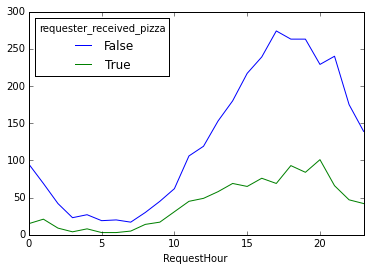

In [27]:
grouped_by_hour = df_pizza_train["unix_timestamp_of_request_readable"].groupby([df_pizza_train["RequestHour"], df_pizza_train["requester_received_pizza"]])
result = grouped_by_hour.apply(lambda x: x.count()).unstack("requester_received_pizza")
result.plot()
#result = grouped_by_hour.describe()
#result.unstack("requester_received_pizza")
#grouped_by_hour.count().plot()
#responsetime_plot = (grouped_by_hour.max()-grouped_by_hour.min()).plot().set_ylabel("Response Hour")

In [28]:
import nltk
train_nouns = []
for text in df_pizza_train["request_text"]:
    tok_text = nltk.word_tokenize(text)
    pos_text = nltk.pos_tag(tok_text)
    text_array = []
    for word, pos in pos_text:
        if pos=='NN':
            text_array.append(word)
    noun = " ".join(text_array)
    train_nouns.append(noun)
train_nouns[:3]

[u'starving artist anything bit unlucky year guy job rent month account banking fee bag afternoon fine point food something bus advance',
 u'money craigslist food money family bread anyone family time reading plea Edit family pizza',
 u'subreddit rest share rent yesterday friday housemate lent dinner advance make awesome place EDIT liter coke']

In [39]:
test_nouns = []
for text in df_pizza_test["request_text"]:
    tok_text = nltk.word_tokenize(text)
    pos_text = nltk.pos_tag(tok_text)
    text_array = []
    for word, pos in pos_text:
        if pos=='NN':
            text_array.append(word)
    noun = " ".join(text_array)
    test_nouns.append(noun)
test_nouns[:3]

[u'exchange sending damnedest likeness body sharpie cash loss part something art student drawing everything power very animal idea face stranger contort part fun',
 u'super recession waitress restaurant na day week position food random pizza something stale box wheat boyfriend home EDIT week',
 u'spending half universe sense today phone week success story http right ol pizza time']

In [29]:
#Topic extraction with non-negative matrix factorization
# Author: Olivier Grisel <olivier.grisel@ensta.org>
#         Lars Buitinck <L.J.Buitinck@uva.nl>
# License: BSD 3 clause

from __future__ import print_function
from time import time

import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.datasets import fetch_20newsgroups


n_samples = 2000
n_features = 1000
n_topics = 50
n_top_words = 100

t0 = time()
print("Loading dataset and extracting TF-IDF features...")

# Extract only nouns from text
dataset = train_nouns

vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=n_features,
                             stop_words='english', strip_accents='unicode')
tfidf = vectorizer.fit_transform(dataset)
print("done in %0.3fs." % (time() - t0))

# Fit the NMF model
print("Fitting the NMF model with n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
nmf = NMF(init='nndsvd', n_components=n_topics, random_state=1).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

feature_names = vectorizer.get_feature_names()

topics = []
for topic_idx, topic in enumerate(nmf.components_):
    topics.append(" ".join([feature_names[i]
                    for i in topic.argsort()[:-n_top_words - 1:-1]]))
    #print("Topic #%d:" % topic_idx)
    #print(topics[-1])
    #print()


Loading dataset and extracting TF-IDF features...
done in 0.143s.
Fitting the NMF model with n_samples=2000 and n_features=1000...
done in 7.083s.


In [34]:
for x in range(3):
    print("Topic #%d:" % x)
    print(topics[-1])
    print()

Topic #0:
job interview luck unemployment lot wife rice check feet life summer boss finding opportunity head debt hunt idea start living wage training half income state temp offer guitar yesterday tuna guy retail phone looking er city point credit try dude avail miracle reading row redditor market restaurant age feeling bunch dad test bike forward shit morning mac mother kindness end dream artist book cheer experience partner blessing wedding past eat pepperoni position thursday conversation bless apartment ate community left economy alot household course worse office use motivation anxiety service stamp halfway nightmare longer date board resume bday contractor season gas

Topic #1:
job interview luck unemployment lot wife rice check feet life summer boss finding opportunity head debt hunt idea start living wage training half income state temp offer guitar yesterday tuna guy retail phone looking er city point credit try dude avail miracle reading row redditor market restaurant age fee

In [35]:
from sklearn.feature_extraction.text import TfidfTransformer 
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(tfidf)

print (tfidf.shape)
print (X_train_tfidf.shape)

(4040, 1000)
(4040, 1000)


In [36]:
y_train_target = df_pizza_train.requester_received_pizza
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train_tfidf, y_train_target)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [40]:
X_test = vectorizer.fit_transform(test_nouns)
X_test_tfidf = tfidf_transformer.transform(X_test)

In [41]:
predicted = clf.predict(X_test_tfidf) 

In [42]:
print (predicted)
y_test_target = df_pizza_test.requester_received_pizza
np.mean(predicted == y_test_target)  

[False False False ..., False False False]


0.72103004291845496

In [45]:
from sklearn import metrics 

In [58]:
#print (pd.Series(vectorizer.vocabulary_))
#vectorizer.vocabulary_.get(u'ability')
vectorizer

TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.95, max_features=1000, min_df=2,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [51]:
df_pizza_train["request_text"][:3]

0    I'm not in College, or a starving artist or an...
1    Hello! It's been a hard 2 months with money an...
2    I'm sure there are needier people on this subr...
Name: request_text, dtype: object

In [52]:
received_a_pizza = []
for text in df_pizza_train["request_text"]:
    counter = 0
    for key in topics[3].split():
        if key in text:
            counter = 1
    received_a_pizza.append(counter)

In [53]:
pd.Series(received_a_pizza).sum()

3542

In [54]:
len(df_pizza_train)

4040

In [63]:
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=n_features,
                             stop_words='english')
vectors = vectorizer.fit_transform(df_pizza_train["request_text"])
vectors.shape

(4040, 1000)

In [64]:
vectors.nnz / float(vectors.shape[0]) 

22.80519801980198

In [65]:
df_pizza_test["request_text"][:3]

4040    'Sright. In exchange for sending me pizza, I w...
4041    She lives in Round Lake Beach, Illinois, which...
4042    After spending two and a half months unemploye...
Name: request_text, dtype: object

In [67]:
request_text_test = df_pizza_test["request_text"]
vectorizer2 = TfidfVectorizer(max_df=0.95, min_df=2, max_features=n_features,
                             stop_words='english')
tfidf2 = vectorizer2.fit_transform(request_text_test.dropna())
#vectorizer.fit_transform(request_text)
#nmf.transform(df_pizza_test["request_text"])

In [68]:
nmf.transform(tfidf2)

array([[ 0.00041882,  0.00092844,  0.00124943, ...,  0.00086949,
         0.00193698,  0.0005337 ],
       [ 0.00032713, -0.        , -0.        , ...,  0.00295789,
         0.00256286,  0.00233939],
       [ 0.00023951,  0.0004359 ,  0.00086895, ...,  0.00218263,
         0.00126268, -0.        ],
       ..., 
       [ 0.0001262 , -0.        , -0.        , ...,  0.00034102,
         0.00041555, -0.        ],
       [ 0.00041201, -0.        ,  0.0003577 , ...,  0.00045122,
         0.00088693,  0.00237658],
       [ 0.00039754,  0.00629546,  0.00023761, ...,  0.0001637 ,
        -0.        ,  0.001053  ]])

In [69]:
vectorizer2.get_feature_names()[:3]

[u'00', u'10', u'100']

In [70]:
import nltk

In [71]:
tokenization_pattern = r'''(?x)    # set flag to allow verbose regexps
([A-Z]\.)+        # abbreviations, e.g. U.S.A.
| \w+(-\w+)*        # words with optional internal hyphens
| \$?\d+(\.\d+)?%?  # currency and percentages, e.g. $12.40, 82%
| \w+[\x90-\xff]  # these are escaped emojis
| [][.,;"'?():-_`]  # these are separate tokens
'''
word_tokenizer = nltk.tokenize.regexp.RegexpTokenizer(tokenization_pattern)

In [72]:
sent_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle') 
sentence = "At eight o'clock on Thursday morning... Arthur didn't feel very good."
tokens = nltk.word_tokenize(sentence)
tokens

['At',
 'eight',
 "o'clock",
 'on',
 'Thursday',
 'morning',
 '...',
 'Arthur',
 'did',
 "n't",
 'feel',
 'very',
 'good',
 '.']

In [73]:
text = nltk.word_tokenize("And now for something completely different. Hi there")
nltk.pos_tag(text) 

[('And', 'CC'),
 ('now', 'RB'),
 ('for', 'IN'),
 ('something', 'NN'),
 ('completely', 'RB'),
 ('different', 'JJ'),
 ('.', '.'),
 ('Hi', 'NNP'),
 ('there', 'RB')]

In [76]:
import nltk.data
text = '''
    Punkt knows that the periods in Mr. Smith and Johann S. Bach
    do not mark sentence boundaries.  And sometimes sentences
    can start with non-capitalized words.  i is a good variable
    name.
... '''
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
print('\n-----\n'.join(sent_detector.tokenize(text.strip())))

Punkt knows that the periods in Mr. Smith and Johann S. Bach
    do not mark sentence boundaries.
-----
And sometimes sentences
    can start with non-capitalized words.
-----
i is a good variable
    name.
-----
...
